# K-Means Classifier.

* **Autor:** Rodrigo Lopez Aburto
* **Versión:** 2.0
* **Fecha:** Marzo 2024

## Summary.

The present NoteBook covers the process of clustering; it starts with the data import process, the exploratory statistical analysis aiming to spot any possible issues within the data, the determination of the optimal number of clusters, the clustering process and to conclusion, a brief analysis of the resulting classes. 

### Libraries.

In [1]:
## Standard Libraries.
import os
import time
import math
import numpy as np
import pandas as pd

## Clustering analysis libraries.
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Data visualization libraries. 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import seaborn as sns

## Data science libraries.
from sklearn.preprocessing import StandardScaler

# KMeans library.
from sklearn.cluster import KMeans

**Functions**

In [2]:
from Funciones.GraphStatEng import *

### Data Import.

The input data set contains well logs from 19 wells, these wells had been cropped to cover data corresponding to the same formation, a sandy-shale. Four well logs were loaded, those relevant to determine the lithology; electric logs were excluded to minimize the impact of fluid content in the clustering process. 

In [3]:
Data = ['DEPT','Well_ID','ECGR','RHOZ','DTCO','NPHI']
Well_logs = ['ECGR','RHOZ','DTCO','NPHI']

In [4]:
currdir = os.getcwd()
df_CHTC = pd.read_csv(currdir + '\\Datos\\Datos_registros_nucleos_CHTC.csv', 
                          usecols=Data, low_memory=False, na_values=-999.25)
df_CHTC_labeled = df_CHTC.copy()
df_CHTC_labeled.dropna(axis=0, inplace=True)
df_CHTC.head(5)

,Well_ID,DEPT,ECGR,RHOZ,DTCO,NPHI
0,A3,1126.0836,107.9460,2.3803,110.1317,0.3453
1,A3,1126.2360,105.3806,2.3843,108.8417,0.3369
2,A3,1126.3884,92.6494,2.4006,106.4857,0.3735
3,A3,1126.5408,85.2163,2.4185,105.1499,0.3418
4,A3,1126.6932,80.9719,2.4253,104.4066,0.3387


In [5]:
print('%i samples were loaded' %df_CHTC_labeled.shape[0])

75238 samples were loaded


## Exploratory Data Analysis.

Se realizo un analisis de los datos con el objetivo, principalmente, de identificar los valores atipicos, revisar la presencia de modas en los datos y explorar de manera general sus caractersiticas. Despues de un primer analisis se decidio realizar una transformacion logaritmica a los registros electricos (AT20 y AT90). 

La tabla con los estadigrafos calculados asi como las diversas graficas obtenidas durante el analisis se guardan en la carpeta de "Resultados" de manera que no todas se muestran en esta seccion. El uso de esta seccion esta contemplado como un complemento al analisis. Se generan las graficas individuales mientras el analisis se conduce en un breve reporte.

Se genera y visualiza una tabla con los estadigrafos de cada registro. La funcion "Estadigrafos" se encuentra en la biblioteca "Funciones", hecha para este notebook. Posteriormente se guarda en formato .csv dentro de la carpeta de resultados.

In [6]:
df_Estadigrafos = Estadigrafos(df_CHTC, Well_logs).round(2)
#df_Estadigrafos.to_csv(currdir + '\Resultados\\Estadigrafos.csv')
df_Estadigrafos

,ECGR,RHOZ,DTCO,NPHI
Samples,75238.00,75238.00,75238.00,75238.00
Minimum,13.81,1.88,45.69,0.02
1st quartile,50.23,2.51,74.64,0.20
Median,61.74,2.55,84.67,0.25
Mean,60.25,2.54,83.23,0.24
3rd quartile,70.33,2.58,90.81,0.28
Maximum,129.00,2.78,116.14,0.50
Range,115.19,0.90,70.45,0.48
IQR,20.10,0.08,16.17,0.08
Variance,231.72,0.00,113.73,0.00


Con el objetivo de analizarse en conjunto con los estadigrafos, se generaron histogramas y boxplots para cada propiedad. Cada uno de los histogramas se guardo en un archivo .png individual que de la misma manera que los estadigrafos se encuentran almacenados en la carpeta de "Resultados".

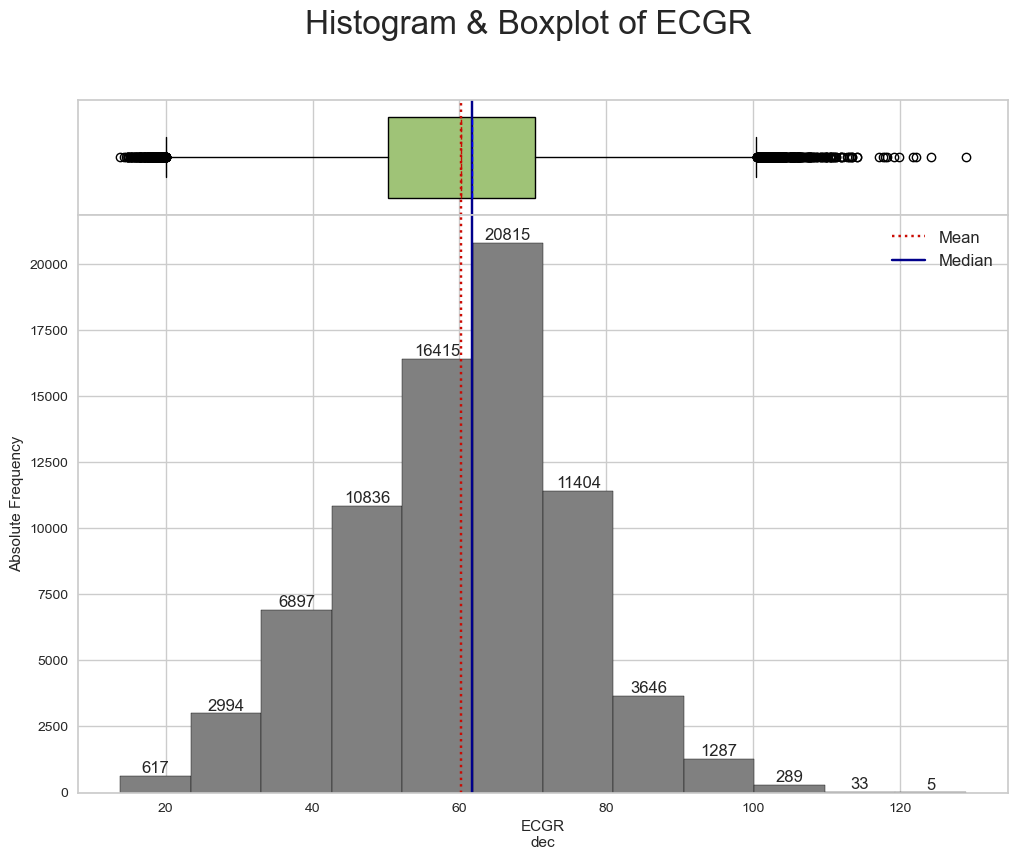

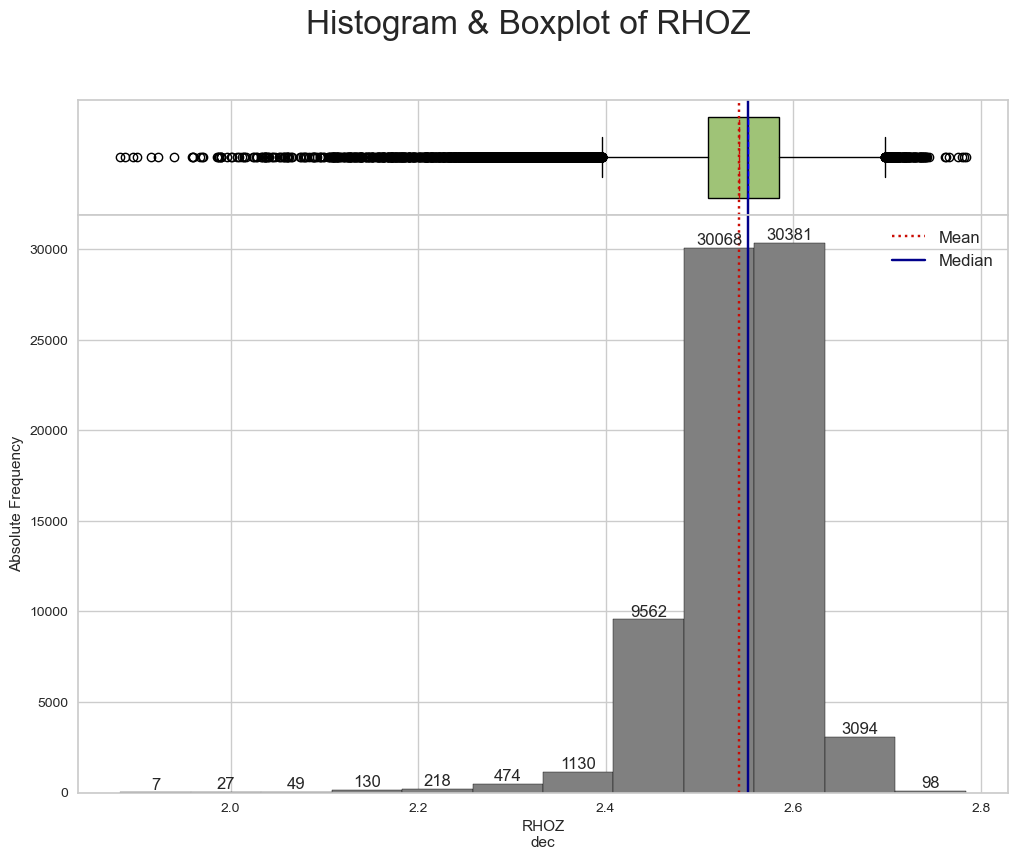

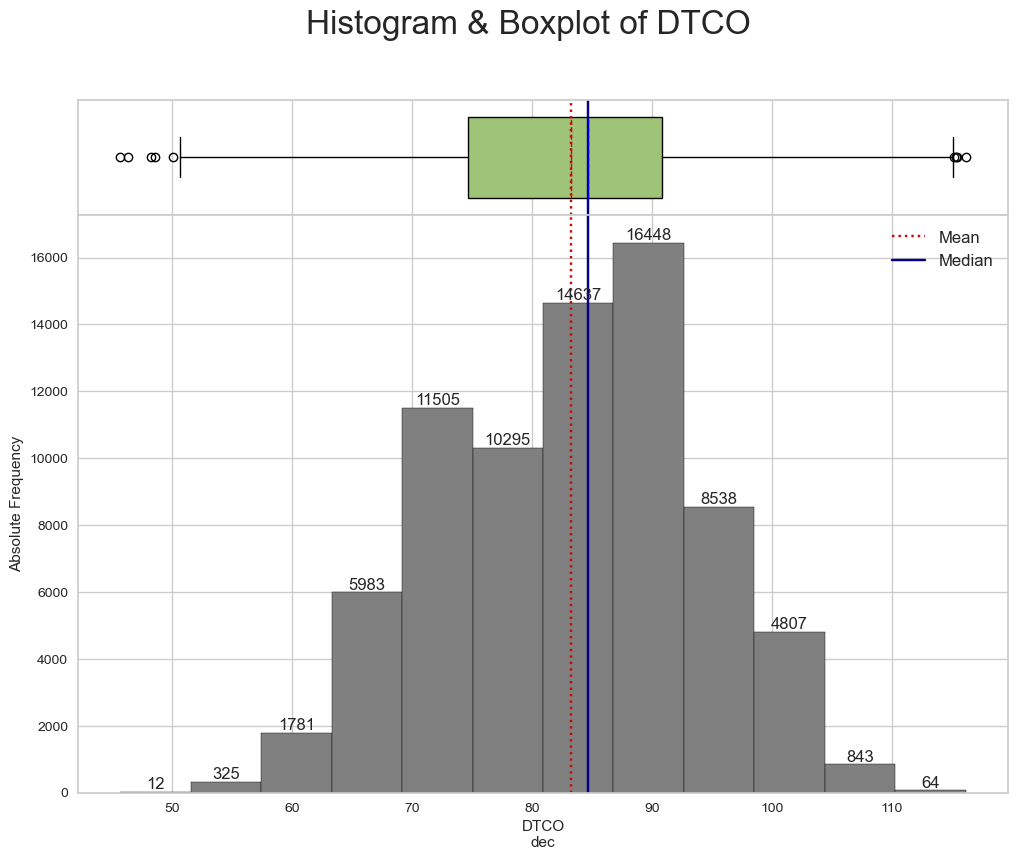

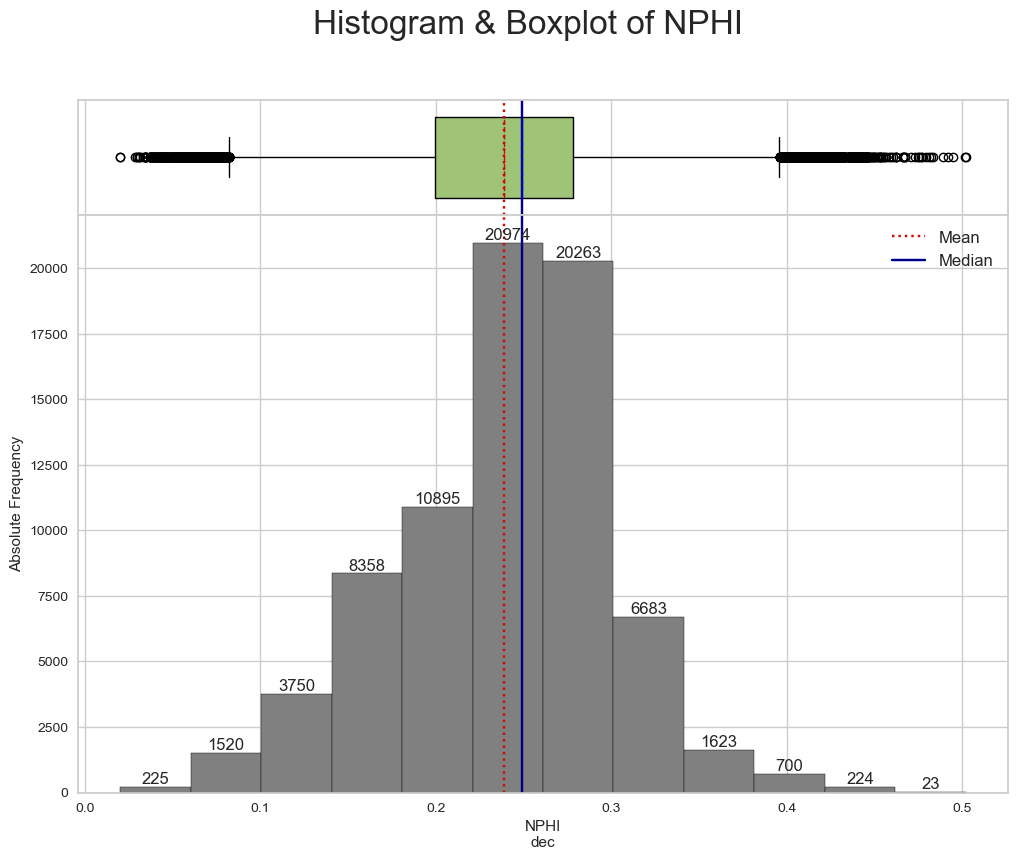

In [7]:
for log in Well_logs:
    fig, axs = Plot_Hist(df_CHTC[log], 12, 'dec', 12);
    fig.savefig(currdir + '\Resultados\\Histograma_%s.png' % log, 
                format="png", bbox_inches="tight", facecolor='white',dpi=300);

## Remocion temporal de valores atipicos

Siguiendo la metodologia del agrupamiento, se realizo un analisis de los valores atipicos. Dicho analisis se realizo a nivel univariado y a nivel multivariado, de ambos analisis se obtuvieron etiquetas para marcar los valores 
Con el objetivo de visualizar mejor la distribucion de los valores atipicos, se marcaron con una etiqueta para su posterior analisis. Con el objetivo de mejorar el desempeño del agrupamiento y como conclusion del analisis hecho en esta seccion se removieron los valores atipicos del proceso de agrupamiento. Una vez obtenido un agrupamiento estos valores removidos se agruparon con la clase mas cercana a los mismos.

**Analisis de atipicos univariado**

El proceso del analisis de atipicos univariados se llevo a cabo mediante la remocion temporal de los mismos con el objetivo de analizar su comportamiento. Durante este analisis, se considero como valor atipico a todos aquellos valores por debajo del primer cuantil menos 1.5 veces el rango intercuantil o todos aquellos valores por encima del tercer cuantil mas 1.5 veces el rango intercuantil. 

El proceso de analisis univariado incluyo la remocion de valores atipicos para observar el comportamiento de los datos. En la mayoria de los casos se observo que nuevos valores atipicos aparecian en los datos.

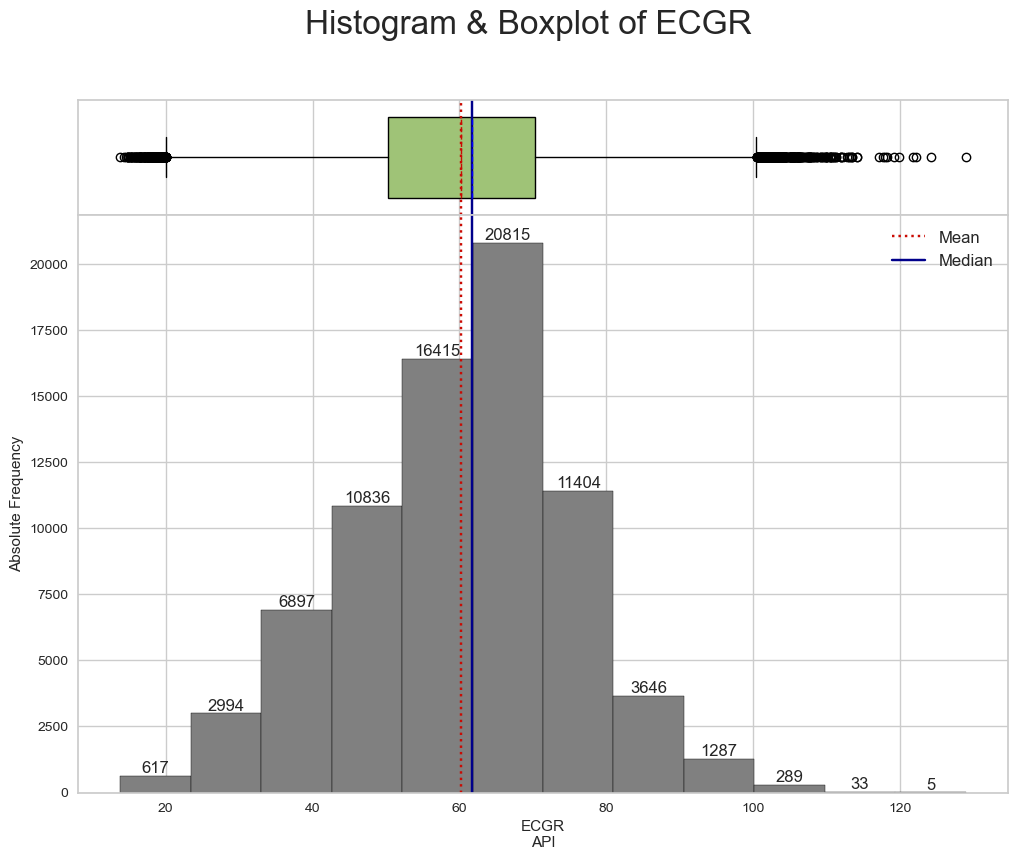

In [8]:
Plot_Hist(df_CHTC['ECGR'], 12, 'API', 12);

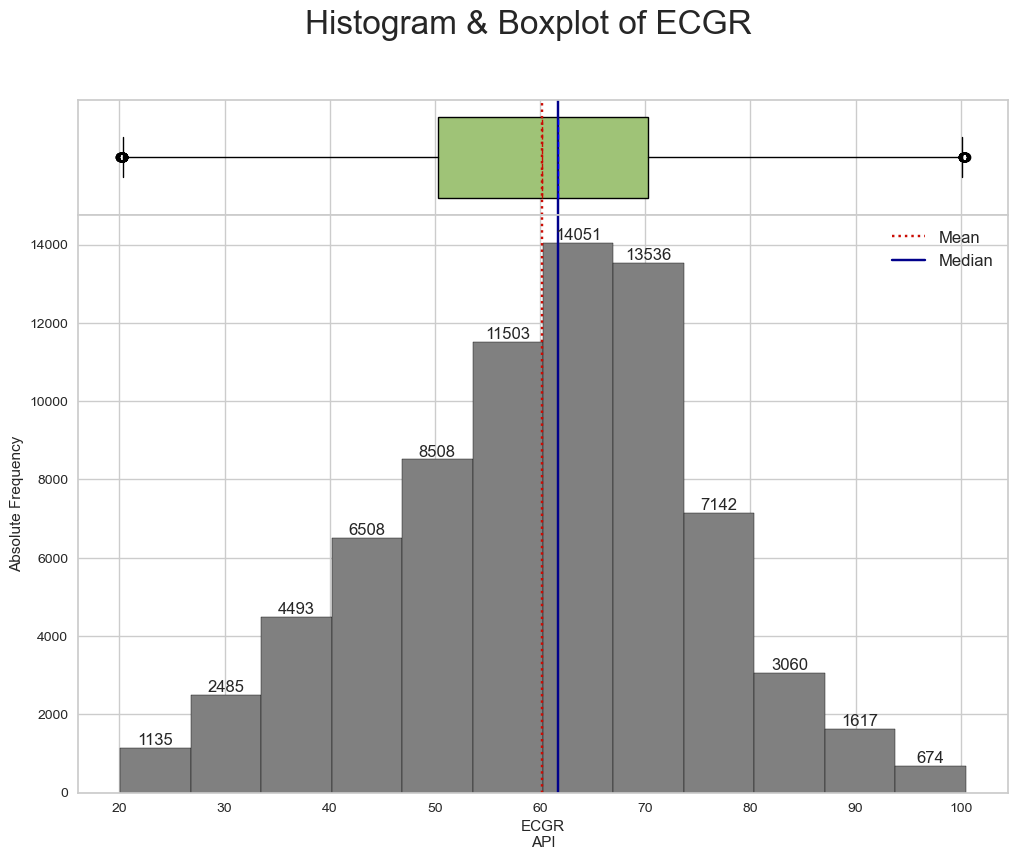

In [9]:
df_temp = Remove_Outliers(df_CHTC, 'ECGR')
Plot_Hist(df_CHTC[df_CHTC['outlier_ECGR'] == 0]['ECGR'], 12, 'API', 12);

**Analisis de valores atipicos multivariado**

Con el objetivo de obtener una mejor idea de los valores atipicos multidimensionales se implemento la metodologia "Local Outlier Factor" (LOF) para etiquetar los valores atipicos multivariados considerando todos los registros cargados. La metodologia LOF involucra el calculo de el "aislameinto" de cada uno de los puntos con respecto al resto de los datos para lo cual el algoritmo hace uso del metodo K-Nearest-Neighbors asi como la distancia del punto en cuestion a cada uno de estos vecinos. En el caso particular de este analisis, se consideraron los 20 vecinos mas cercanos para definir los atipicos multidimensionales.

In [10]:
clf = LocalOutlierFactor(n_neighbors=75)
y_pred = clf.fit_predict(df_CHTC[['ECGR','RHOZ','DTCO','NPHI']])
X_scores = clf.negative_outlier_factor_

In [11]:
n_inliers = (y_pred == 1).sum(); print(f"Number of inliers: {n_inliers}")
n_outliers = (y_pred == -1).sum(); print(f"Number of outliers: {n_outliers}")
n_total = n_inliers + n_outliers; print(f"Total: {n_total}")

Number of inliers: 74934
Number of outliers: 304
Total: 75238


Con el objetivo de visualizar la posicion de los valores atipicos multidimensionales es posible utilizar graficos de dispersion para cada par de registros geofisicos.

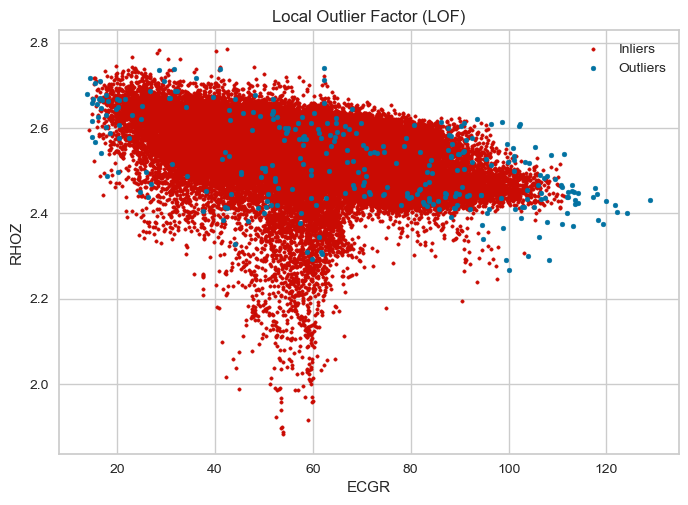

In [12]:
ds_numpy = df_CHTC[['ECGR','RHOZ','DTCO','NPHI']].to_numpy()
colors = np.array(["#377eb8", "#ff7f00"])
good = ds_numpy[y_pred == 1]
outliers = ds_numpy[y_pred == -1]

plt.title("Local Outlier Factor (LOF)")

plt.scatter(good[:, 0], good[:, 1], color='r', s=6.0, label="Inliers")
plt.scatter(outliers[:, 0], outliers[:, 1], color='b', s=12.0, label="Outliers")

legend = plt.legend()
plt.xlabel('ECGR')
plt.ylabel('RHOZ')
#plt.show()
plt.savefig(currdir + '\Resultados\\LOC_Plot.png',format="png", bbox_inches="tight", facecolor='white', dpi=300);

De manera mas general, es posible visualizar este tipo de graficas en una matriz. Se observa que de manera general los valores atipicos multivariados se encuentran hacia los bordes de los datos.

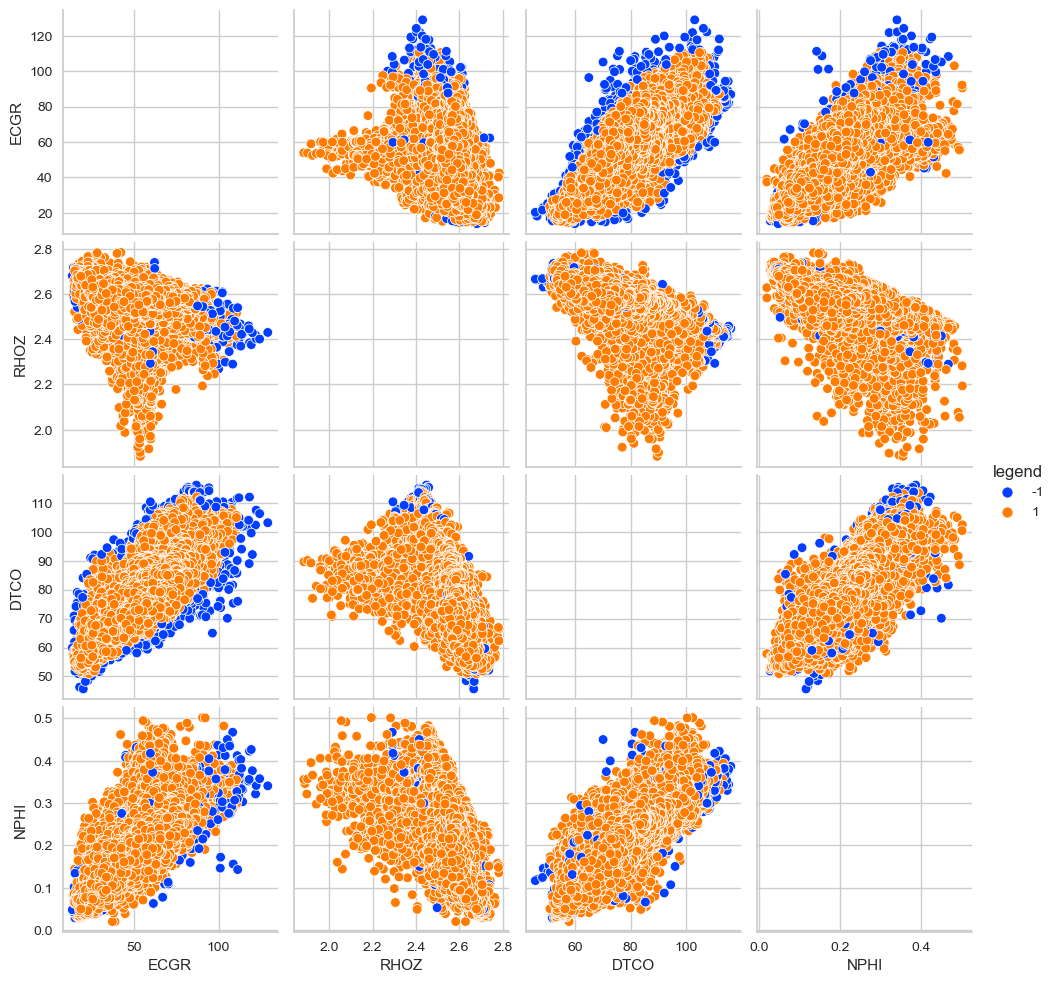

In [13]:
sns.color_palette('bright')
data = df_CHTC[['ECGR','RHOZ','DTCO','NPHI']].copy()
data.columns=['ECGR','RHOZ','DTCO','NPHI']
data['legend'] = y_pred
sns.pairplot(data, hue='legend', palette='bright',diag_kind='none')
#plt.show()
plt.savefig(currdir + '\Resultados\\Outliers.png', format="png", bbox_inches="tight", facecolor='white')

La remocion temporal de los valores atipicos multivariados se realizo creando un nuevo DataFrame que contuviera unicamente los valores etiquetados como inliers.

In [14]:
df_CHTC_inliers = df_CHTC[y_pred == 1]

## Estandarización de los datos.

Una vez obtenidos los datos dispuestos para el agrupamieinto, el siguiente paso es la estandarizacion de los mismos con el objetivo de eliminar la disparidad entre los rangos debida a las distintas unidades de medida de los mismos. El proceso de estandarizacion resta el valor de la media a los mismos para luego escalarlos a una varianza unitaria. Se generaron histogramas con el objetivo de visualizar los datos transformados. Cada uno de estos histogramas y boxplots se guardan en la carpeta de "Resultados".

**Standarization by well**

In [15]:
Pozos = list(df_CHTC['Well_ID'].value_counts(sort=False).index)

In [16]:
resultado = []
scaler = StandardScaler()
for pozo in Pozos:
    standarized_data = scaler.fit_transform(df_CHTC_inliers[df_CHTC_inliers['Well_ID'] == pozo][Well_logs])
    resultado = resultado + standarized_data.tolist()
df_standard = pd.DataFrame(resultado, columns=Well_logs, index=df_CHTC_inliers.index)
Estadigrafos(df_standard,['ECGR','RHOZ','DTCO','NPHI']).round(2)

,ECGR,RHOZ,DTCO,NPHI
Samples,74934.00,74934.00,74934.00,74934.00
Minimum,-5.47,-10.67,-3.88,-4.49
1st quartile,-0.61,-0.65,-0.78,-0.68
Median,0.22,0.02,0.19,0.23
Mean,-0.00,0.00,0.00,-0.00
3rd quartile,0.71,0.65,0.74,0.71
Maximum,3.72,5.40,3.29,5.55
Range,9.19,16.06,7.17,10.04
IQR,1.33,1.30,1.53,1.39
Variance,1.00,1.00,1.00,1.00


**Global standarization**

In [17]:
#scaler = StandardScaler()
#df_original_Standard = scaler.fit_transform(df_inliers[registros_geofisicos]) 
#df_standard = pd.DataFrame(df_original_Standard, columns=registros_geofisicos, index=df_inliers.index)
#for registro in registros_geofisicos:
#    fig, axs = Plot_Hist(df_standard[registro], 12, 'dec', 12);
#    fig.savefig(currdir + '\Resultados\\Histograma_%s_std.png' % registro,
#                format="png", bbox_inches="tight", facecolor='white', dpi=300);

In [18]:
#df_CHTC_standard = pd.concat([df_CHTC['DEPT'],df_CHTC['Well_ID'],df_standard], axis=1)
#df_CHTC_standard.head(5)

## Data splitting.

Although an 75,000 samples data set might not seem lengthy at first, severa practical applications require the use of much more samples; it is a good practice to extract a representative sample from the bigger data set aiming to reduce the computational time of the clustering process.

In this particular case, 25% of the data was extracted (random samples) to conduct the clustering process. The proof of this sample's representativeness is shown using the boxplot and statistics for both data sets.

In [19]:
df_CHTC_short = df_CHTC_inliers.sample(frac=0.25, random_state=5, axis=0)
df_standard_short = df_standard.sample(frac=0.25, random_state=5, axis=0)

In [20]:
Estadigrafos(df_standard,['ECGR','RHOZ','DTCO','NPHI']).round(2)

,ECGR,RHOZ,DTCO,NPHI
Samples,74934.00,74934.00,74934.00,74934.00
Minimum,-5.47,-10.67,-3.88,-4.49
1st quartile,-0.61,-0.65,-0.78,-0.68
Median,0.22,0.02,0.19,0.23
Mean,-0.00,0.00,0.00,-0.00
3rd quartile,0.71,0.65,0.74,0.71
Maximum,3.72,5.40,3.29,5.55
Range,9.19,16.06,7.17,10.04
IQR,1.33,1.30,1.53,1.39
Variance,1.00,1.00,1.00,1.00


In [21]:
Estadigrafos(df_standard_short,['ECGR','RHOZ','DTCO','NPHI']).round(2)

,ECGR,RHOZ,DTCO,NPHI
Samples,18734.00,18734.00,18734.00,18734.00
Minimum,-4.17,-9.75,-3.88,-4.03
1st quartile,-0.62,-0.64,-0.79,-0.68
Median,0.23,0.03,0.18,0.23
Mean,-0.00,-0.01,-0.00,0.01
3rd quartile,0.71,0.64,0.74,0.71
Maximum,3.72,4.91,3.16,4.22
Range,7.89,14.66,7.04,8.24
IQR,1.33,1.28,1.53,1.40
Variance,1.00,0.99,1.00,1.00


[]

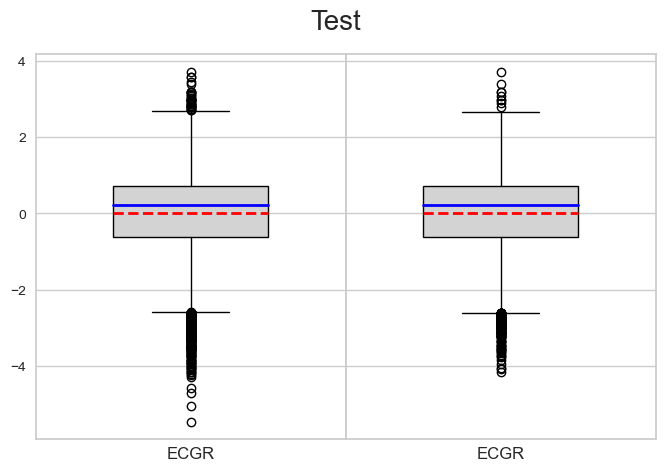

In [22]:
label = 'ECGR'
fig, axs = plt.subplots(1, 2, figsize=(8,5), sharey=True)
fig.suptitle('Test', size=20, y=0.97)
plt.subplots_adjust(wspace=0, hspace=0)

## Original Dataframe
axs[0].boxplot(df_standard[label],vert=True, meanline=True, showmeans=True, widths=0.50, patch_artist=True,
                 boxprops={'facecolor':'lightgrey'}, medianprops={'color':'blue','linewidth':2},
                 meanprops={'color':'red','linewidth':2})
axs[0].set_title('%s' %label, y=-0.07)
axs[0].set_xticks([])

## Sampled Dataframe
axs[1].boxplot(df_standard_short[label],vert=True, meanline=True, showmeans=True, widths=0.50, patch_artist=True,
                 boxprops={'facecolor':'lightgrey'}, medianprops={'color':'blue','linewidth':2},
                 meanprops={'color':'red','linewidth':2})
axs[1].set_title('%s' %label, y=-0.07)
axs[1].set_xticks([])

## Determinacion del numero optimo de clusters.

Una vez estandarizados los datos, el siguiente paso de la metodologia es la determinacion del numero optimo de clusters para lo cual existen diversas tecnicas capaces de ayudar en la determinacion de este numero. En esta seccion se presentan 5 metodos distintos. 

**Método del Codo**

Este metodo consiste en la aplicacion de manera secuencial del agrupamiento (KMeans en este caso) para diferentes numeros de clusters. Una vez obtenidos los clusters, se calcula la "inercia" que no es mas que la suma de todas las distacias entre cada uno de los puntos y el centroide de su cluster correspondiente.

In [23]:
#model = KMeans(n_init=10, random_state=42)
#visualizer = KElbowVisualizer(model, k=(2,20))
#visualizer.fit(df_standard_short[Well_logs])
#visualizer.show()
#plt.savefig(currdir + '\Resultados\\Elbow.png', format="png", bbox_inches="tight", facecolor='white')

**Método de la Silueta**

Este metodo se basa en la integracion de dos conceptos, para su implementacion se requiere calcular la "similitud" y la "disimilitud" de cada uno de los puntos en referncia a los demas.
La "similitud" se refiere a la distancia entre el punto en cuestion y el resto de los puntos dentro del cluster al que pertenece mientras que la "disimilitud" se refiere a la distancia entre el punto en cuestion y los puntos de los clusters a los que no pertenece. El metodo de la silueta entonces toma estos dos conceptos para dertminar que tan bien diferenciado se encuentra el punto en cuestion respecto al resto.

In [24]:
#Silhouette_plots(df_standard_short[Well_logs],[3,6,12,13])

In [25]:
#Silhouette(df_standard_short[Well_logs],ks=range(2, 20))
#plt.savefig(currdir + '\Resultados\\Silhouete.png', format="png", bbox_inches="tight", facecolor='white')

**Calinski-Harabasz Index (Variance Ratio Criterion, VRC)**

Este metodo consiste en el calculo de dos sumatorias de las distancias al cuadrado. La primer sumatoria se construye tomando la distancia de los puntos de cada cluster con respecto a su centroide mientras que la segunda corresponde a la distancia entre los puntos de cada cluster con respecto a los clusters adyacentes. De esta manera, este metodo considera no solo la relacion de cada cluster con los demas sino que tambien considera la constitucion del mismo cluster.

In [26]:
#CH_Index(df_standard_short[Well_logs],ks=range(2,30))
#plt.savefig(currdir + '\Resultados\\CH_Index.png', format="png", bbox_inches="tight", facecolor='white')

**Davies-Bouldin Index**

Este metodo consiste en comparar los clusters obtenidos de manera sistematica. El indice en cuestion es una medida de que tan parecidos son los clusters tomando como criterio principal la distanica de los puntos de cada cluster y su centroide asi como la distancia entre los clusters. 

In [27]:
#DB_Index(df_standard_short[Well_logs],ks=range(2, 20))
#plt.savefig(currdir + '\Resultados\\DB_Index.png', format="png", bbox_inches="tight", facecolor='white')

**Método del Gap**

Este metodo busca encontrar la maxima diferencia entre los valores de la sumatoria de las distancias internas de cada cluster para lo cual calcula de manera secuencial un agrupamiento, su respectiva distanica intra-cluster y posteriormente un nuevo agrupamiento con un cluster mas que el caso anterior de manera que se pueda comparar la distancia intra-cluster de ambos escenarios. 

In [28]:
#df_temp = optimalK(df_standard_short[Well_logs], nrefs=5, maxClusters=20)
#plt.plot(df_temp['clusterCount'], df_temp['gap'], linestyle='--', marker='o', color='b');
#plt.xlabel('K');
#plt.ylabel('Gap Statistic');
#plt.title('Gap Statistic vs. K');
#plt.savefig(currdir + '\Resultados\\Gap.png', format="png", bbox_inches="tight", facecolor='white')

**Conclusion**

Considerando los resultados obtenidos por los diversos metodos, se tomo la decision de implementar dos agrupamientos, uno con 6 clases y uno con 4 clases. Esto es considerando que la cantidad de clusters presente en los datos deberia ser un numero entre 2 y 6 considerando las particularidades de los datos y la aplicacion para la cual seran dispuestos. La construccion de clases petrofisicas implica que estas sean petrofisicamente diferenciables, algo que no se logra en caso de tener un elevado numero de clusters.

## KMeans application (4 clases).

In [29]:
start_time = time.time()
kmeans = KMeans(n_clusters=4, random_state=0, n_init=1000)
kmeans.fit(df_standard_short[Well_logs][Well_logs].to_numpy())
finish_time = time.time(); tiempo_entrenamiento_4C = finish_time - start_time
print('El tiempo que tarda entrenar es de ', tiempo_entrenamiento_4C, 'segundos') 

El tiempo que tarda entrenar es de  22.836901664733887 segundos


In [30]:
Class_4_Predict = kmeans.predict(df_standard_short[Well_logs].to_numpy()) 
df_4 = pd.DataFrame(Class_4_Predict, columns=['KMeans_4_Clases'], index=df_standard_short.index)

**Reclasificación**
Por practicidad, se intercambio el orden de las clases.

In [31]:
df_4.replace({1:0,3:1,0:2,2:3},inplace=True)

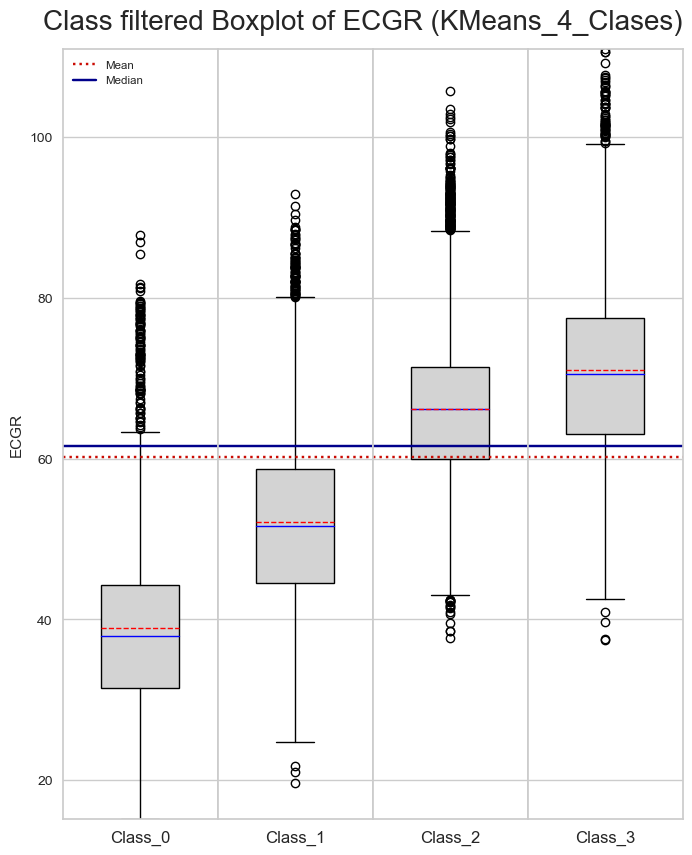

In [32]:
df_Class4 = pd.concat([df_CHTC_short,df_4], axis=1)
df_Class4_standard = pd.concat([df_standard_short,df_4], axis=1)

Class_Boxplots(df_Class4, 'ECGR', 'KMeans_4_Clases');
#plt.savefig(currdir + '\Resultados\\Boxplot_por_clase.png', format="png", bbox_inches="tight", facecolor='white')

### Archivo de salida

Se genero un archivo separado por comas con los registros originales y las clasificaciones. 

In [33]:
df_complete = pd.read_csv(currdir + '\\Datos\\Datos_registros_nucleos_CHTC.csv', low_memory=False, na_values=-999.25)
df_Clasificado = pd.concat([df_complete,df_4], axis=1)
df_Clasificado.to_csv(currdir + '\\Resultados\\Nucleos_Etiquetados_Clasificados_KMeans.csv', na_rep=-999.25, index=False)

### Visualización de los resultados.

<Axes: xlabel='ECGR', ylabel='DTCO'>

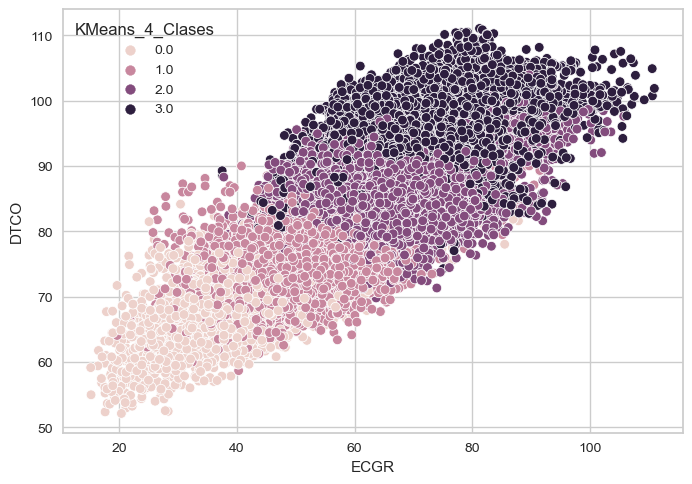

In [34]:
sns.scatterplot(data=df_Clasificado, x='ECGR', y='DTCO', hue='KMeans_4_Clases')

## Analisis de las clasificaciones

Considerando la clasificacion de 4 clases petrofisicas (criterio estadistico), se realizo un analisis estadistico para tratar de obtener su sentido geologico, de manera similar al de las facies (criterio geologico).

**Conteo de las clases**

In [35]:
df_Class4['KMeans_4_Clases'].value_counts()

2    7068
1    4838
3    4444
0    2384
Name: KMeans_4_Clases, dtype: int64

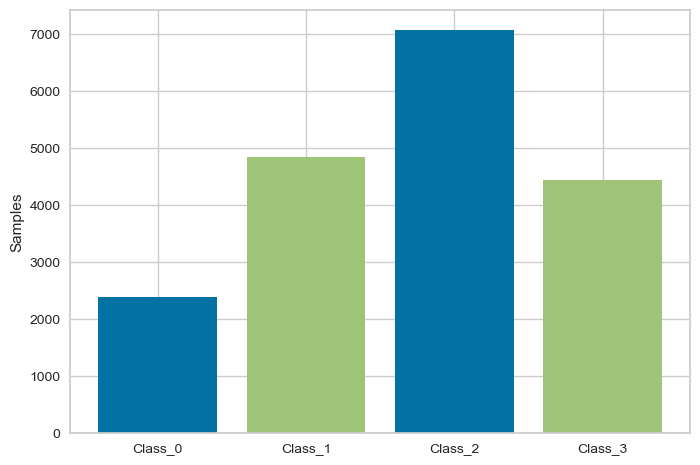

In [36]:
temp = df_Class4['KMeans_4_Clases'].value_counts().sort_index()
plt.bar(x=temp.index, height=temp.values, color=['b','g','b','g'], tick_label=['Class_0','Class_1','Class_2','Class_3'])
plt.ylabel("Samples")
plt.savefig(currdir + '\Resultados\\ClassCount.png', format="png", bbox_inches="tight", facecolor='white', dpi=300);

**Clase Petrofisica 0 (Arena)**

La clase 0 es la que menos valores cuenta en comparacion con las demas, con tan solo 215 muestras de un total de 1993. Considerando el valor de 'ECGR' es posible afirmar que esta es la clase menos arcillosa de todas con una mediana de 30.87 °API. El valor de la mediana para RHOZ, DTCO y NPHI tambien sugieren que esta clase podria estar conformada por rocas con un mayor contenido de arena. En cuanto a los registros resistivos, de ellos no es posible obtener mucha informacion de la litologia, sin embargo, con un valor de la mediana de 20 y valores minimos cercanos a 8 es posible asumir que su contenido de arcilla es bajo.

Comparativamente con las facies, se observa que la clase 0 tiene su aporte mayoritario en la Facie 1 la cual esta descrita como lutitas moteadas.

In [37]:
Estadigrafos(df_Class4[df_Class4['KMeans_4_Clases'] == 0], ['ECGR','RHOZ','DTCO','NPHI']).round(2)

,ECGR,RHOZ,DTCO,NPHI
Samples,2384.00,2384.00,2384.00,2384.00
Minimum,15.15,2.41,52.14,0.02
1st quartile,31.49,2.57,64.30,0.11
Median,37.90,2.61,68.22,0.14
Mean,38.96,2.60,68.48,0.14
3rd quartile,44.32,2.63,72.16,0.17
Maximum,87.81,2.77,89.32,0.26
Range,72.66,0.36,37.18,0.24
IQR,12.82,0.06,7.86,0.06
Variance,134.83,0.00,37.68,0.00


**Clase Petrofisica 1 (Arena-Arcillosa)**

Con 714 muestras, esta es la clase con mayor cantidad de muestras en comparacion con las demas. Considerando el valor de la mediana de ECGR, el cual es el segundo mayor de entre las clasificaciones, es posible que se trate de arcillas con un contenido de medio a bajo de arenas. La mediana del registro de RHOZ se acerca mas al valor de una arenisca de granos de quarzo que una arcilla, sin embargo, considerando las particularidades de la arena y cementante calcareo de chicontepec es posible que la densidad mas alta de lo normal se deba a este fenomeno. El valor de la mediana de NPHI es tambine inusualmente alto. Los registros resisitivos tienen valores minimos congruentes con lutitas.

Considerando la contribucion de las facies a las clases petrofisicas, se observa que la clase 1 esta constituida principalmente de lutitas moteadas (Facie 1), lutitas laminadas y areniscas (Facie 3) y lutitas en estratos delgados (Facie 5).

In [38]:
Estadigrafos(df_Class4[df_Class4['KMeans_4_Clases'] == 1], ['ECGR','RHOZ','DTCO','NPHI']).round(2)

,ECGR,RHOZ,DTCO,NPHI
Samples,4838.00,4838.00,4838.00,4838.00
Minimum,19.63,2.17,58.70,0.08
1st quartile,44.48,2.54,71.31,0.18
Median,51.66,2.57,74.30,0.20
Mean,52.09,2.56,75.50,0.20
3rd quartile,58.73,2.60,78.68,0.23
Maximum,92.89,2.72,94.67,0.32
Range,73.25,0.54,35.97,0.24
IQR,14.25,0.06,7.37,0.05
Variance,118.13,0.00,38.94,0.00


**Clase Petrofisica 2 (Arcilla)**

Con 379 muestras, esta es la segunda clase con menor cantidad de muestras. Considerando el valor de la mediana para ECGR el cual es el mas alto de las 4 clases es posible que se trate de la clase mas arcillosa. El valor de la mediana en RHOZ es el mas bajo de todas las clases lo cual sugiere lo mismo. El valor de la mediana de NPHI es el mas alto y los valores de la mediana de los registros resistivos son bajos. De manera general los registros sugieren que se trata de la clase mas arcillosa de entre las 4.

Comparativamente con las facies se observa que la principal contribucion proviene de la facies 5 y 7 las cuales corresponden a lobulos y depositos de derrumbe respectivamente.

In [39]:
Estadigrafos(df_Class4[df_Class4['KMeans_4_Clases'] == 2], ['ECGR','RHOZ','DTCO','NPHI']).round(2)

,ECGR,RHOZ,DTCO,NPHI
Samples,7068.00,7068.00,7068.00,7068.00
Minimum,37.75,2.32,68.67,0.17
1st quartile,59.97,2.53,83.31,0.24
Median,66.14,2.56,86.49,0.26
Mean,66.14,2.55,86.68,0.26
3rd quartile,71.34,2.58,90.22,0.28
Maximum,105.69,2.65,104.47,0.37
Range,67.95,0.33,35.80,0.21
IQR,11.37,0.05,6.91,0.03
Variance,88.78,0.00,31.64,0.00


**Clase Petrofisica 3 (Arcilla-Arenosa)**

Con 638 muestras, esta es la segunda clase mas grande. El valor de la mediana de ECGR es el segundo mas bajo lo cual sugiere que la arcillosidad es menor en comparacion con la clase 1, la cual es la mas abundante. Los valores de las medianas de RHOZ, DTCO y NPHI tambien son congruentes con la hipotesis de que la clase 3 es una contraparte menos arcillosa de la clase 1.

Observando las facies, la mayor contribucion a la clase 3 proviene de la facie 1 la cual corresponde a lutitas moteadas.

In [40]:
Estadigrafos(df_Class4[df_Class4['KMeans_4_Clases'] == 3], ['ECGR','RHOZ','DTCO','NPHI']).round(2)

,ECGR,RHOZ,DTCO,NPHI
Samples,4444.00,4444.00,4444.00,4444.00
Minimum,37.48,1.89,70.63,0.18
1st quartile,63.01,2.45,89.90,0.27
Median,70.48,2.50,93.51,0.29
Mean,70.97,2.48,94.17,0.30
3rd quartile,77.53,2.52,99.32,0.32
Maximum,110.90,2.59,111.06,0.49
Range,73.42,0.70,40.43,0.31
IQR,14.51,0.07,9.42,0.05
Variance,126.84,0.01,39.19,0.00


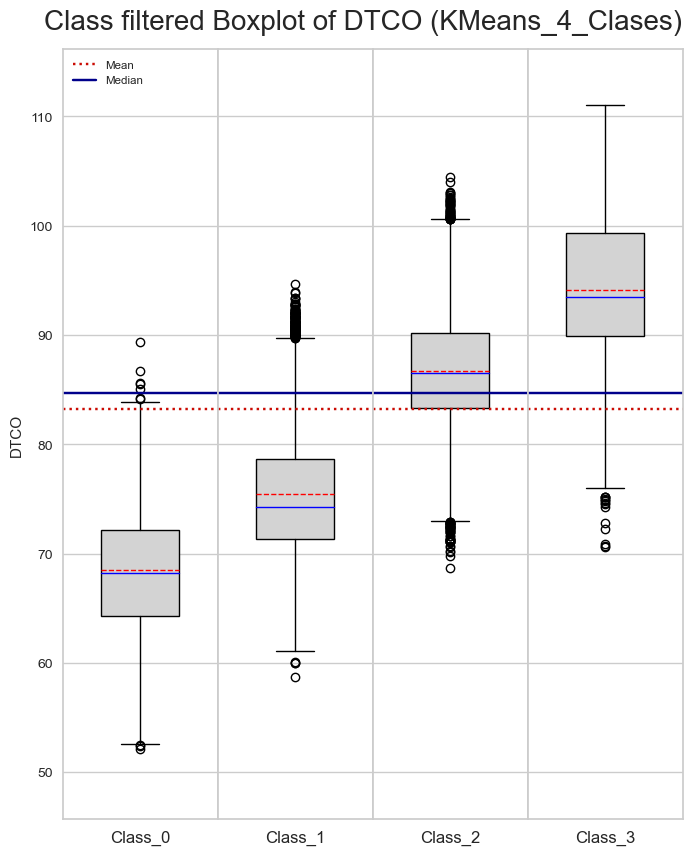

In [41]:
Class_Boxplots(df_Clasificado, 'DTCO', 'KMeans_4_Clases');
plt.savefig(currdir + '\Resultados\\Boxplot_Class.png', format="png", bbox_inches="tight", facecolor='white')

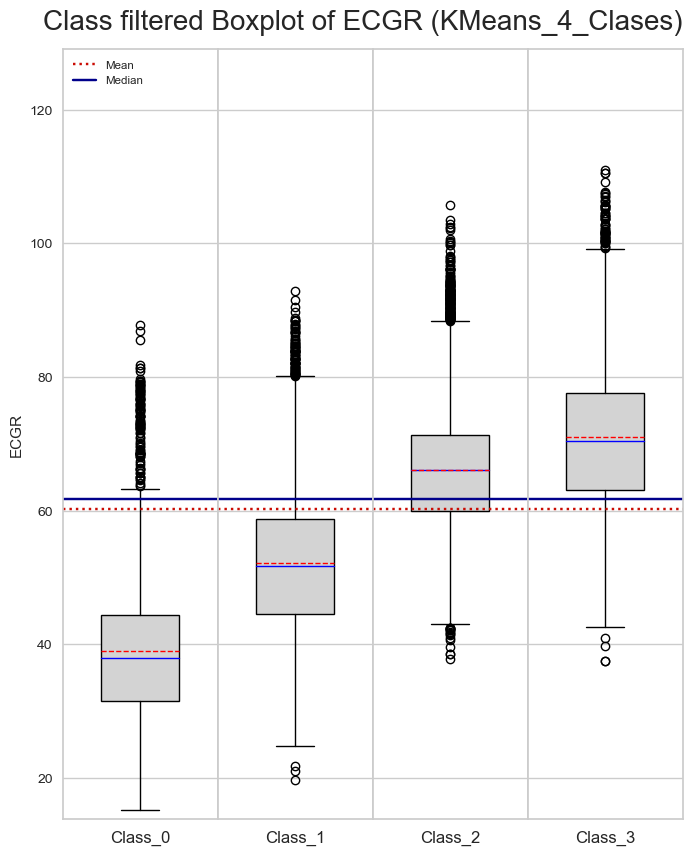

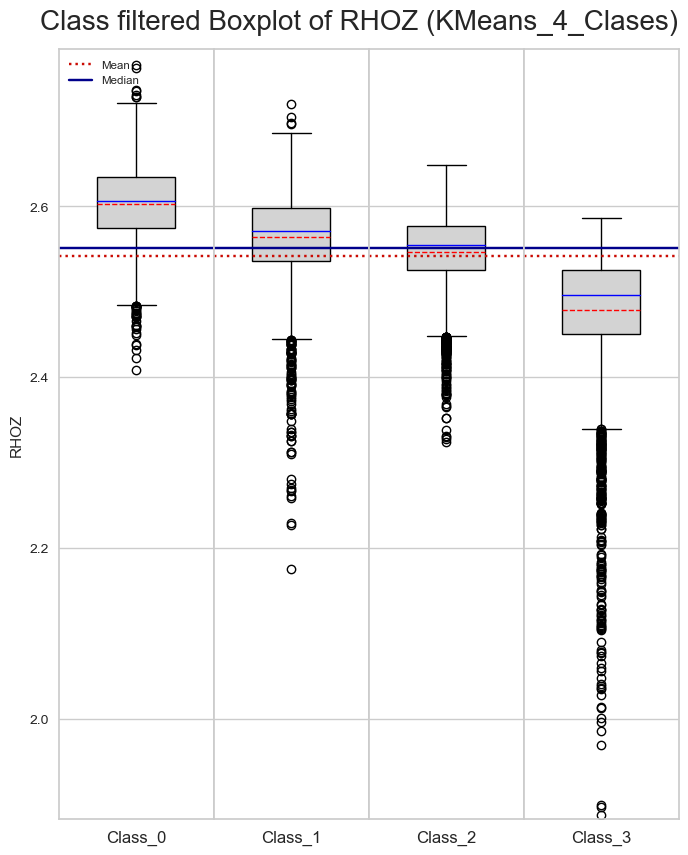

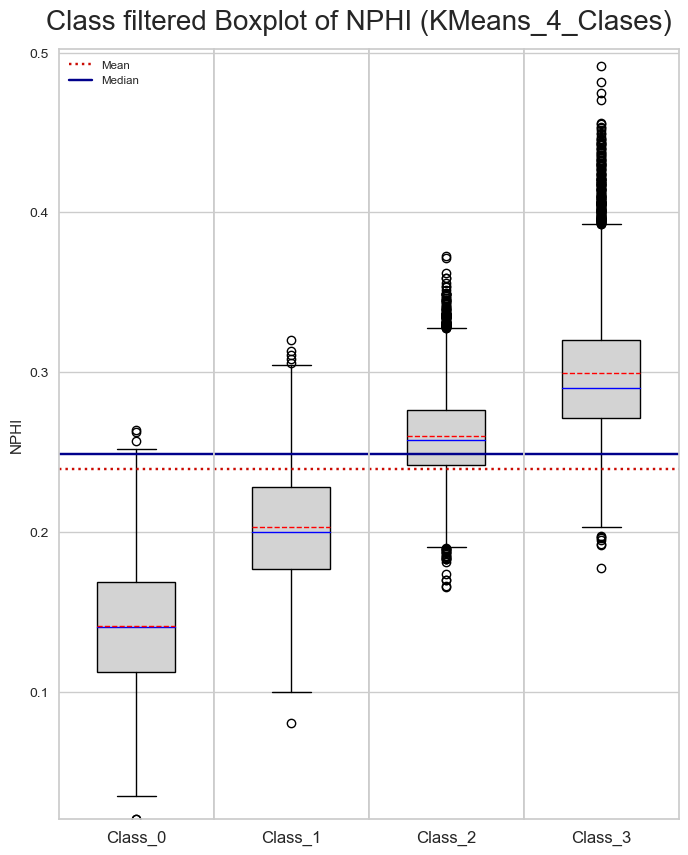

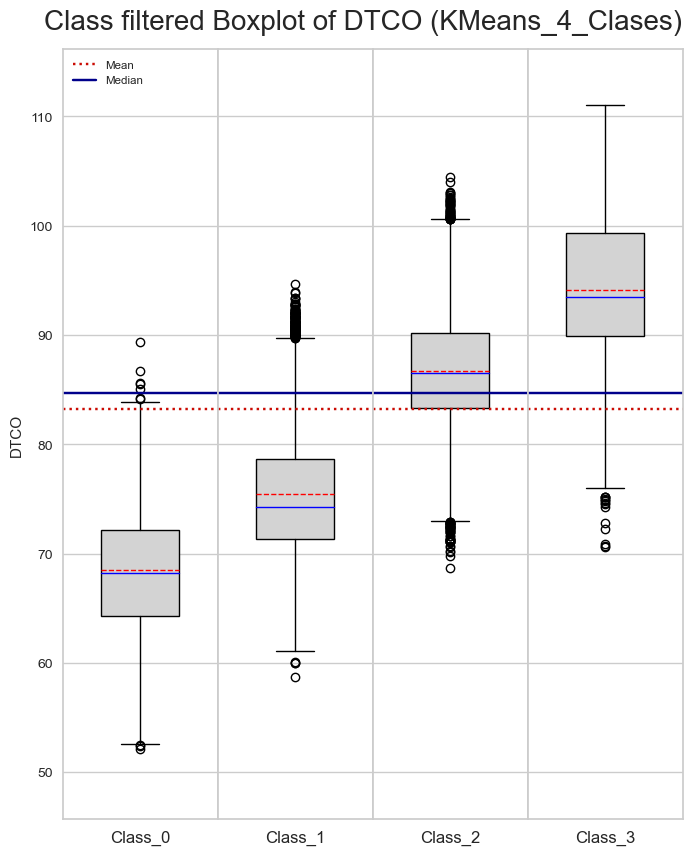

In [42]:
Clases = ['KMeans_4_Clases']
Registros_Boxplots = ['ECGR','RHOZ','NPHI','DTCO']
for registro in Registros_Boxplots:
    for clase in Clases:
        fig, axs = Class_Boxplots(df_Clasificado, registro, clase);
        fig.savefig(currdir + '\Resultados\\Boxplot_de_%s_para_%s.png' % (registro, clase), 
                    format="png", bbox_inches="tight", facecolor='white', dpi=300);

# Extras

Buscando comparar la clasificacion geologica con las obtenidas en este punto, se construyeron matrices de confusion para lo cual, usando los boxplots filtrados por clasificacion se propuso un agrupamiento secundario de las clases 

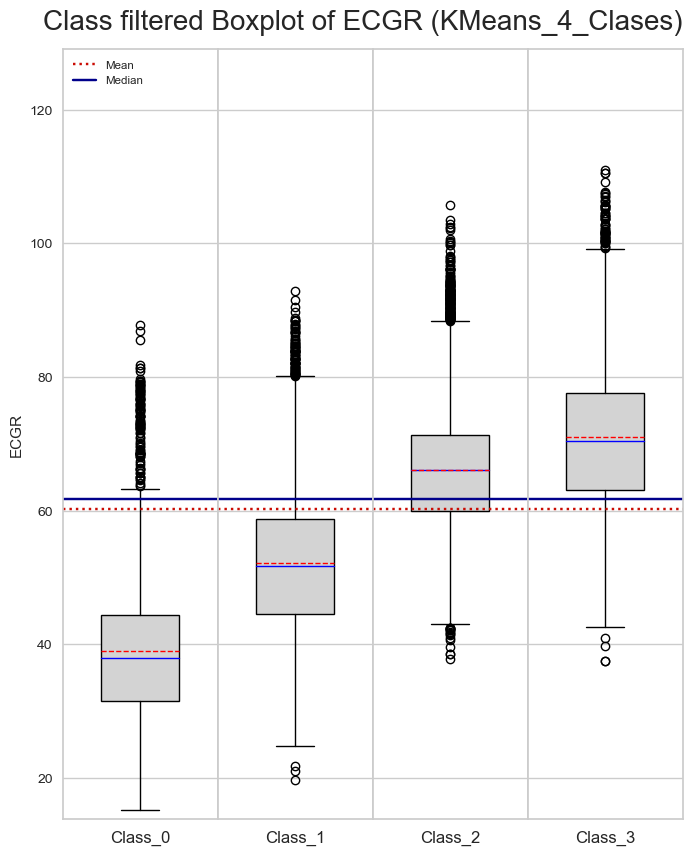

In [43]:
fig1, axs1 = Class_Boxplots(df_Clasificado, 'ECGR', 'KMeans_4_Clases');